In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/training"
    testing_dir = "/content/drive/MyDrive/testing"
    train_batch_size = 64
    train_number_epochs = 100




In [ ]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        # 두 이미지가 서로 다른 클래스면 1
        # 두 이미지가 서로 같은 클래스면 0

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

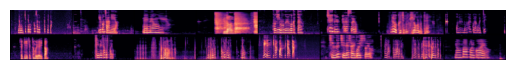

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((99,250)),transforms.ToTensor()])
                                       ,should_invert=False)


vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated)) # 여러 개 이미지 합쳐서 grid로 반환
print(example_batch[2].numpy()) # 두 이미지가 같은 클래스인지에 대한 label

In [ ]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1), # 가장자리의 특징들까지 고려
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*99*250, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flatten
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0): # 두 샘플사이의 거리가 marigin보다 크면 손실 발생. 이하면 손실 0
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + # 같은 클래스 쌍에 대한 손실
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 다른 클래스 쌍에 대한 손실

        return loss_contrastive

Epoch number 0
 Current loss 0.31557559967041016

Epoch number 1
 Current loss 45.17539596557617

Epoch number 2
 Current loss 13.620646476745605

Epoch number 3
 Current loss 5.207791328430176

Epoch number 4
 Current loss 5.772343158721924

Epoch number 5
 Current loss 3.8805837631225586

Epoch number 6
 Current loss 2.107182025909424

Epoch number 7
 Current loss 1.3432929515838623

Epoch number 8
 Current loss 1.1888139247894287

Epoch number 9
 Current loss 1.4939254522323608

Epoch number 10
 Current loss 0.7623215913772583

Epoch number 11
 Current loss 1.1824151277542114

Epoch number 12
 Current loss 0.5401096940040588

Epoch number 13
 Current loss 0.4417020082473755

Epoch number 14
 Current loss 0.6352831721305847

Epoch number 15
 Current loss 0.48956137895584106

Epoch number 16
 Current loss 0.3079630732536316

Epoch number 17
 Current loss 0.266659140586853

Epoch number 18
 Current loss 0.29506218433380127

Epoch number 19
 Current loss 0.15322339534759521

Epoch numbe

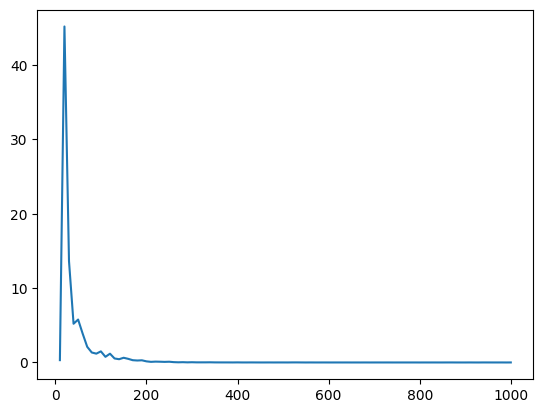

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )


counter = []
loss_history = []
iteration_number= 0


for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
print(loss_history[-1])

0.004989389330148697


In [ ]:
torch.save(net,'siamese_net_v3.pt')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("siamese_net_v1.pt", map_location=device)
print(model)

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


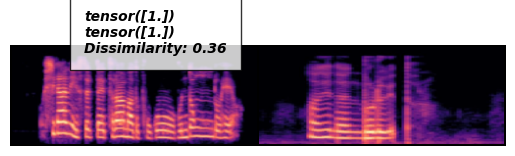

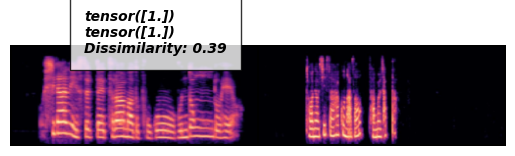

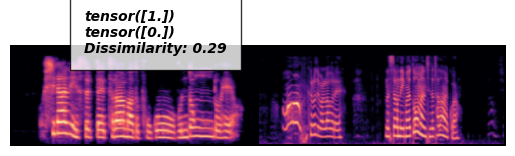

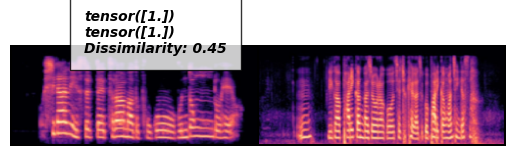

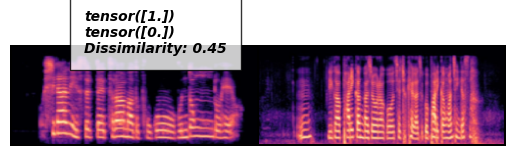

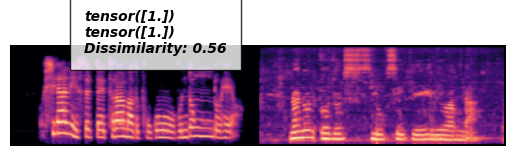

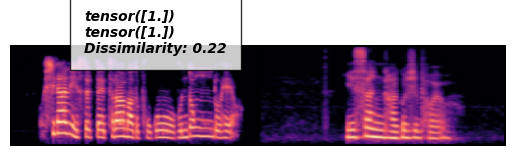

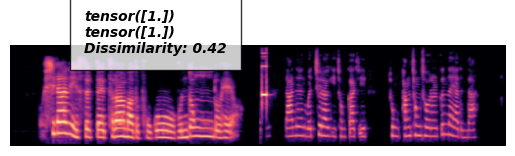

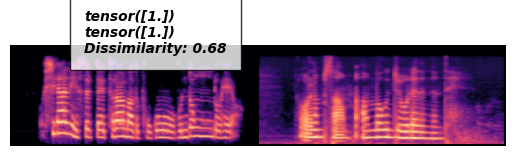

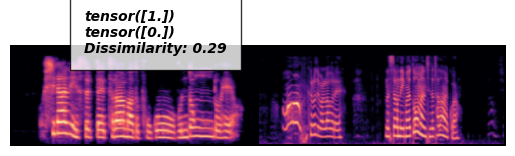

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((99,250)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)


dataiter = iter(test_dataloader)
x0,_,label1 = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'{}\n{}\nDissimilarity: {:.2f}'.format(label1[0],label2[0],euclidean_distance.item()))

In [ ]:
def compute_accuracy(model, test_loader, threshold=0.5):
    correct = 0
    total = 0

    model.eval()  # 평가 모드로 설정

    with torch.no_grad():
        for data1, data2, labels in test_loader:

            data1, data2, labels = data1.cuda(), data2.cuda(), labels.cuda()
            output1, output2 = model(data1, data2)

            euclidean_distance = F.pairwise_distance(output1, output2)
            predicted = (euclidean_distance > threshold).float()  # 유사성을 확인하기 위한 임계값 적용
            print(euclidean_distance)
            print(predicted)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"correct : {correct}" )
    print(f"total : {total}")
    return accuracy

acc = compute_accuracy(net, test_dataloader)
print(acc)

tensor([1.9399], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([2.1799], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.0986], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.9715], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.0986], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.4311], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.4442], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.2174], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.5372], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.4616], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.1778], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.7753], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.6585], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.8092], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.3895], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.6731], device='cuda:0')
tensor